In [14]:
from collections import namedtuple
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm_notebook

from style_bank_net import TransformerNet
from utils import gram_matrix, recover_image, tensor_normalizer

%matplotlib inline

In [2]:
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    print 'avalilable'
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 2, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}

avalilable


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
DATASET = "data_contents/"
transform = transforms.Compose([transforms.Scale(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [4]:
LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_2", "relu4_2"])

# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '13': "relu3_2",
            '20': "relu4_2"
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [5]:
vgg_model = vgg.vgg16(pretrained=True)
if torch.cuda.is_available():
    vgg_model.cuda()
loss_network = LossNetwork(vgg_model)
loss_network.eval()
del vgg_model

(1, 3, 300, 300)


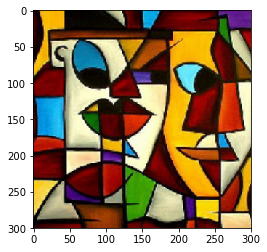

In [6]:
STYLE_IMAGE = "data_styles/style_images/picasso.png"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
plt.imshow(style_img)
style_img_tensor = transforms.Compose([
    transforms.Scale(400),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    tensor_normalizer()]
)(style_img).unsqueeze(0)
# assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
if torch.cuda.is_available():
    style_img_tensor = style_img_tensor.cuda()

print style_img_tensor.cpu().numpy().shape
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])
plt.show()

In [7]:
# http://pytorch.org/docs/master/notes/autograd.html#volatile
style_loss_features = loss_network(Variable(style_img_tensor, volatile=True))
gram_style = [Variable(gram_matrix(y).data, requires_grad=False) for y in style_loss_features]
print gram_style[0].numel()

4096


## Train the Transformer / Image Generator
Utility function to save debug images during training:

In [8]:
def save_debug_image(tensor_orig, tensor_transformed, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 2 + 5, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.save(filename)

In [9]:
%mkdir -p debug

In [10]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
if torch.cuda.is_available():
    transformer.cuda()

In [13]:
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 100
LOG_INTERVAL = 200
REGULARIZATION = 1e-7
EPOCH = 100
T = 5
LAMBDA = 1

LR = 1e-2
optimizer = Adam(transformer.parameters(), LR, )
transformer.train()

for epoch in range(EPOCH):
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.
    agg_identity_loss = 0.
    count = 0
    t = 0
    
    for batch_id, (x, _) in enumerate(train_loader):
#         if t == 0:
#             optimizer.zero_grad()
#         t += 1
        optimizer.zero_grad()
    
        n_batch = len(x)
        count += n_batch
        x = Variable(x)
        if torch.cuda.is_available():
            x = x.cuda()
        y = transformer(x, style_mode = True)
        
        xc = Variable(x.data, volatile=True)
        features_y = loss_network(y)
        features_xc = loss_network(xc)

        # content loss at relu4_2 
        f_xc_c = Variable(features_xc[3].data, requires_grad=False)
        content_loss = CONTENT_WEIGHT * mse_loss(features_y[3], f_xc_c)
        reg_loss = REGULARIZATION * (
            torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        style_loss = 0.
        for m in range(len(features_y)):
            gram_s = gram_style[m]
            gram_y = gram_matrix(features_y[m])
            style_loss += STYLE_WEIGHT * mse_loss(gram_y, gram_s.expand_as(gram_y))

        total_loss = content_loss + style_loss + reg_loss
        total_loss.backward()
        optimizer.step()
        
#         sizes,sums = 0.,0.
#         for param in transformer.named_parameters():
#             if  'style' in param[0]: continue
#             sums += param[1].grad.abs().sum()
            
#             p = 1
#             for d in param[1].size(): p *= d
#             sizes += p
#         norm_style = sums/sizes
            
#         if t == T:
#             t = 0
#             optimizer.step()
            
#             # auto-encoder training
#             optimizer.zero_grad()
#             y = transformer(x, style_mode = False)
#             identity_loss = mse_loss(y, x)
#             identity_loss.backward()
            
#             sizes,sums = 0.,0.
#             for param in transformer.named_parameters():
#                 if  'style' in param[0]: continue
#                 sums += param[1].grad.abs().sum()

#                 p = 1
#                 for d in param[1].size(): p *= d
#                 sizes += p
#             norm_encoder = sums/sizes
            
#             for param in transformer.named_parameters():
#                 if  'style' in param[0]: continue
#                 param[1].grad = LAMBDA * norm_style / norm_encoder * param[1].grad 

#             optimizer.step()
#             agg_identity_loss += identity_loss.data[0]
            
        agg_content_loss += content_loss.data[0]
        agg_style_loss += style_loss.data[0]
        agg_reg_loss += reg_loss.data[0]

        
        if (batch_id + 1) % LOG_INTERVAL == 0:
            mesg = "{} [{}/{}] content: {:.6f}  style: {:.6f}  reg: {:.6f}  identity: {:.6f} total: {:.6f}".format(
                        time.ctime(), count, len(train_dataset),
                        agg_content_loss / LOG_INTERVAL,
                        agg_style_loss / LOG_INTERVAL,
                        agg_reg_loss / LOG_INTERVAL,
                        agg_identity_loss / LOG_INTERVAL,
                        (agg_content_loss + agg_style_loss + agg_reg_loss) / LOG_INTERVAL
                    )
            print(mesg)
            agg_content_loss = 0.
            agg_style_loss = 0.
            agg_reg_loss = 0.
            agg_identity_loss = 0.
            transformer.eval()
            y = transformer(x, style_mode = True)
            save_debug_image(x.data, y.data, "debug/{}_{}.png".format(epoch, count))
            transformer.train()

Mon Oct 16 13:01:51 2017 [800/999] content: 4.322757  style: 0.117493  reg: 0.013684  identity: 0.000000 total: 4.453934
Mon Oct 16 13:02:49 2017 [800/999] content: 3.727939  style: 0.114926  reg: 0.014730  identity: 0.000000 total: 3.857595
Mon Oct 16 13:03:48 2017 [800/999] content: 3.253713  style: 0.113148  reg: 0.015606  identity: 0.000000 total: 3.382467
Mon Oct 16 13:04:46 2017 [800/999] content: 2.796643  style: 0.111418  reg: 0.016686  identity: 0.000000 total: 2.924747


KeyboardInterrupt: 

Process Process-24:
Process Process-23:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/qzq/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/qzq/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/home/qzq/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/qzq/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/home/qzq/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
  File "/home/qzq/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()
  File "/home/qzq/anaconda2/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/home/qzq/anaconda2/lib/pyt

In [ ]:
    print param

In [21]:
print transformer.conv1.parameters

<bound method ConvLayer.parameters of ConvLayer (
  (reflection_pad): ReflectionPad2d (4, 4, 4, 4)
  (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
)>


In [45]:
a = Variable(torch.ones(5), requires_grad=True)
b = Variable(torch.ones(5)*5, requires_grad=True)


In [49]:
c = sum(a*b)
d = 5*c
d.backward()

In [50]:
a.grad

Variable containing:
 50
 50
 50
 50
 50
[torch.cuda.FloatTensor of size 5 (GPU 0)]

In [51]:
b.grad

Variable containing:
 10
 10
 10
 10
 10
[torch.cuda.FloatTensor of size 5 (GPU 0)]